# 2D Plotting

This tutorial is an introduction to using Neuropythy to plot the 3D cortices of either FreeSurfer or HCP subjects. 

**Author**: &nbsp;&nbsp; [Noah C. Benson](mailto:nben@uw.edu)  
**Date**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; June 05, 2022  
**Link**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [noahbenson/neuropythy-tutorials](https://github.com/noahbenson/neuropythy-tutorials)

## Setup

To start with, we need to import various libraries. These include, first, neuropythy itself, and, second, the ipyvolume library for 3D plotting. We also import various utility libraries like os and sys.

In [1]:
# Import some standard/utility libraries:
import os, sys, six # six provides python 2/3 compatibility

# Import our numerical/scientific libraries, scipy and numpy:
import numpy as np
import scipy as sp

# The neuropythy library is a swiss-army-knife for handling MRI data, especially
# anatomical/structural data such as that produced by FreeSurfer or the HCP.
# https://github.com/noahbenson/neuropythy
import neuropythy as ny

# Import graphics libraries:
# Matplotlib/Pyplot is our 2D graphing library:
import matplotlib as mpl
import matplotlib.pyplot as plt

# We also import ipyvolume, the 3D graphics library used by neurropythy, for 3D
# surface rendering (optional).
import ipyvolume as ipv

In [2]:
# These "magic commands" tell matplotlib that we want to plot figures inline and
# That we are using qt as a backend; due to bugs in certain versions of
# matplotlib, we put them in a separate cell from the import statements above
# and the configuration statements below.
%matplotlib inline

## Choose a Subject

We need a subject whose ROIs we are going to draw. This notebook uses the subject `'bert'`, who is included in the docker-image that is part of the tutorials repository and with any FreeSurfer installation. You can optionally configure neuropythy to know where your FreeSurfer subjects directory is, allowing you to load subjects by their names alone (see [this page](https://github.com/noahbenson/neuropythy/wiki/Configuration) for information on configuring neuropythy), but the easiest way to ensure that you load the subject you intend to is to pass the subject's full path.

In [3]:
# If you aren't running the tutorial in the docker-image, make sure to set this
# to a FreeSurfer subject directory that you have access to locally.
sub = ny.freesurfer_subject('/data/freesurfer_subjects/bert')

## Creating a 2D Cortical Surface (a "flatmap")

Neuropythy has a system for creating flattened 2D cortical meshes (or, typically, sub-meshes). This system uses the `ny.map_projection` function to create "flatmaps". All flatmaps made using this method are projections of a cortical sphere. To make a flatmap, one typically just needs a point on the cortical sphere to use as the center of the map, and another point to rotate onto the positive *x*-axis of the resulting 2D projection.

Here, we'll walk through some of these concepts.

### Cortical Spheres ("registrations")

Each `Cortex` object (that is, each hemisphere) of a subject has attached to it both "surfaces" and "registrations". Registrations and surfaces are both 3D meshes, but registratons specifically are all spherical meshes. Typically, they have a radius of 100.

In [4]:
sphere = sub.lh.registrations['native']
(x,y,z) = sphere.coordinates
r = np.sqrt(x**2 + y**2 + z**2)
(np.mean(r), np.std(r))

(99.99999996992226, 2.0952864332288513e-06)

The `'fsaverage'` sphere is the subject's hemisphere after registration to to FreeSurfer's *fsaverage* atlas hemisphere. Using this sphere for flatmaps has the advantage that all flatmaps will be anatomically aligned (but, simultaneously, the flatmaps will  reflect space in a way that is less faithful to the subject's 3D cortical surface).

In [5]:
reg_fsa = sub.lh.registrations['fsaverage']
reg_nat = sub.lh.registrations['native']
ny.cortex_plot((reg_nat,reg_fsa.translate([250,0,0])))

Figure(camera=PerspectiveCamera(fov=0.644570721372708, position=(0.0, -100.0, 0.0), projectionMatrix=(1.0, 0.0…

### Mask-based Flatmaps

The easiest way to create a flatmap is usually to use the `mask_flatmap` method of the `Cortex` class, which creates a flatmap centered on a particular mask (see `help(ny.to_mask)` and the plotting tutorial for more information about masks).

We'll use the `'cortex_label'` property (which is `True` everywhere that isn't part of the medial wall) as the mask; this will center the flatmap on the lateral side of the brain.

We can also tell the flatmap what direction to point toward the right side of the map. Since we're visualizing the lateral part of the left hemisphere, we'll set the right to be posterior.

In [6]:
flatmap = sub.lh.mask_flatmap('cortex_label', 
                              map_right='posterior',
                              method='orthographic',
                              radius=np.pi/2)

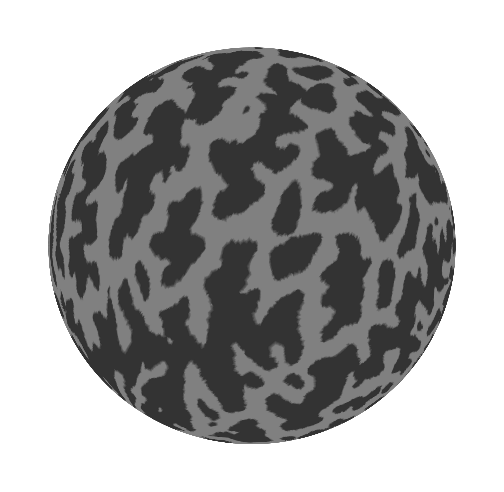

In [7]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=72*4)

ny.cortex_plot(flatmap, axes=ax)

ax.axis('off');

In [8]:
help(sub.lh.mask_flatmap)

Help on method mask_flatmap in module neuropythy.geometry.mesh:

mask_flatmap(mask, map_right='anterior', radius=Ellipsis, method=Ellipsis, pre_affine=Ellipsis, post_affine=Ellipsis, meta_data=Ellipsis, registration='native') method of neuropythy.mri.core.Cortex instance
    hemi.mask_flatmap(mask) yields a flatmap of the given hemisphere that is centered on the
      middle of the given mask.
    
    The following options may be given:
      * radius (default: Ellipsis) is passed along to the map_projection() function.
      * method (default: Ellipsis) is passed along to the map_projection() function.
      * pre_affine (default: Ellipsis) is passed along to the map_projection() function.
      * post_affine (default: Ellipsis) is passed along to the map_projection() function.
      * meta_data (default: Ellipsis) is passed along to the map_projection() function.
      * map_right (default: 'anterior') may be a direction ('anterior', 'posterior', 'inferior',
        'superior', 'lef

### Using MapProjections

To make flatmaps using the *fsaverage* registration, you can use the `map_projection` function. This function takes a number of options, which are documented in its doc-string; you can view this documentation below, but we'll walk through some of these examples as well.

In [9]:
help(ny.map_projection)

Help on function map_projection in module neuropythy.geometry.mesh:

map_projection(name=None, chirality=Ellipsis, center=Ellipsis, center_right=Ellipsis, radius=Ellipsis, method=Ellipsis, registration=Ellipsis, sphere_radius=Ellipsis, pre_affine=Ellipsis, post_affine=Ellipsis, meta_data=Ellipsis, remember=False)
    map_projection(name, hemi) yields the map projection with the given name if it exists; hemi must
      be either 'lh', 'rh', or 'lr'/None.
    map_projection(name, topo) yields a map projection using the given topology object topo to
      determine the hemisphere and assigning to the resulting projection's 'mesh' parameter the
      appropriate registration from the given topology.
    map_projection(name, mesh) uses the given mesh; the mesh's meta-data must specify the hemisphere
      for this to work--otherwise 'lr' is always used as the hemisphere.
    map_projection(affine, hemi) creates a map projection from the given affine matrix, which must
      align a set of s

As a simple example, we can make a projection that is centered on V1 (also known as primary visual cortex or striate cortex). In order to do this, we'll need to execute a few steps:
1. Figure out where V1 is on cortex--we'll need to pass this to the `map_projection` function as the `center` option.
2. Figure out what part of cortex we want to put on the map's positive x-axis (though, with V1, we can typically use the cartesian left or right side of the brain).
3. Decide how big of a flatmap we want to make--this should be the number of radians of the cortical sphere that we want to include in the flatmap, usually this is between pi/4 and pi/2.
4. Decide what kind of map projection method we want to use--this can be "orthographic", "equirectangular", "sinusoidal", or "mercator".

We'll create map projections for both the left and right hemisphere simultaneously in the following cell.

In [10]:
# First, let's grab the fsaverage subject from FreeSurfer. This should work
# even if you don't have your SUBJECTS_DIR configured and if you haven't
# already told neuropythy's configuration where it can find FreeSurfer
# subjects (or if you're running this tutorial in the docker-image), but it
# might take awhile because neuropythy will have to download a dataset in
# order to load the subject.
fsaverage = ny.freesurfer_subject('fsaverage')

# Next, let's find the location of V1. We can do this using the 'V1_weight'
# property, which gives the probability that each vertex on the cortical
# surface is in V1, based on anatomical alignment.
v1_centers = {}
for h in ['lh', 'rh']:
    # Get the Cortex object for this hemisphere.
    cortex = fsaverage.hemis[h]
    # We're dealing with the cortical sphere, so get that surface.
    sphere = cortex.registrations['native']
    # Grab the V1_weight property and the coordinates.
    v1_weight = sphere.prop('V1_weight')
    coords = sphere.coordinates
    # Now, we can take a weighted average of the coordinates in V1.
    v1_center = np.sum(coords * v1_weight[None,:], axis=1)
    v1_center /= np.sum(v1_weight)
    # Save this in the v1_centers dict.
    v1_centers[h] = v1_center

# See what got saved:
v1_centers

{'lh': array([ 37.79666838, -70.80057563, -54.63788443]),
 'rh': array([-60.23899003, -55.23617797, -52.21611106])}

In [11]:
# Okay, we have the center of our map projection; now let's find the
# point that we intend to put on the positive x-axis. For the left
# hemisphere, we can intuitively use the medial wall's center point
# as this landmark; for the right hemisphere, we'll need the antipodal
# point (i.e., the point across from the medial wall's center).
v1_rights = {}
for h in ['lh', 'rh']:
    # Once again, we get the Cortex object for this hemisphere and the
    # spherical surface.
    cortex = fsaverage.hemis[h]
    sphere = cortex.registrations['native']
    # Now, we want the cortex_label property, which is True for points not
    # on the medial wall and False for points on the medial wall.
    weight = sphere.prop('cortex_label')
    # We want to find the point at the middle of the medial wall, so we
    # want to invert this property (True values indicate the medial wall).
    weight = ~weight
    # Now we take the weighted average again (however, since these weight
    # values are all True or False (1 or 0), we can just average the
    # points that are included.
    mwall_center = np.mean(coords[:, weight], axis=1)
    # If this is the RH, we invert this coordinate
    v1_rights[h] = -mwall_center if h == 'rh' else mwall_center

# See what got saved.
v1_rights

{'lh': array([ 61.1048203 ,  27.73087493, -58.39053144]),
 'rh': array([ 65.44048432, -42.47869361,  42.30694955])}

In [12]:
# Okay, now we just need to decide what kind of map to make and how much
# of the cortical sphere to include. These parameters can be changed to
# see how the maps differ based on different choices.
method = 'orthographic' # or: equirectangular, sinusoidal, mercator
radius = np.pi/2

# Now, we make the projections:
map_projs = {}
for h in ['lh', 'rh']: 
    # Note that the last parameter here is the registration; by setting this
    # to 'fsaverage' means that when this map projection is used to make a
    # flatmap of a subject's cortex, it will use their fsaverage-aligned
    # registration for the projection. This causes the maps of subjects to
    # appear roughly similar despite differences in anatomical structure.
    mp = ny.map_projection(chirality=h,
                           center=v1_centers[h],
                           center_right=v1_rights[h],
                           method=method,
                           radius=radius,
                           registration='fsaverage')
    map_projs[h] = mp

# See what this created.
map_projs

{'lh': MapProjection(<LH>, <fsaverage>),
 'rh': MapProjection(<RH>, <fsaverage>)}

Note that in the above cells, we created `MapProjection` objects, but these objects are not meshes or cortices. Rather, they are simple objects that know how to create a flatmap when given a `Cortex` object. So, in order to create a flatmap for our subject, we need to pass the appropriate hemisphere to the appropriate `MapProjection`.

Note that this cell may take a minute or so to run--this is typical when first creating a flatmap because neuropythy often needs to first read in the appropriate spherical mesh for the subject then calculate the new 2D coordinates. However, it should not be more than a minute, typically.

In [13]:
flatmaps = {h: mp(sub.hemis[h]) for (h,mp) in map_projs.items()}
flatmaps

{'lh': Mesh(<2D>, <133203 faces>, <66911 vertices>),
 'rh': Mesh(<2D>, <137351 faces>, <68967 vertices>)}

Now that we've made the flatmaps, let's go ahead and plot them!

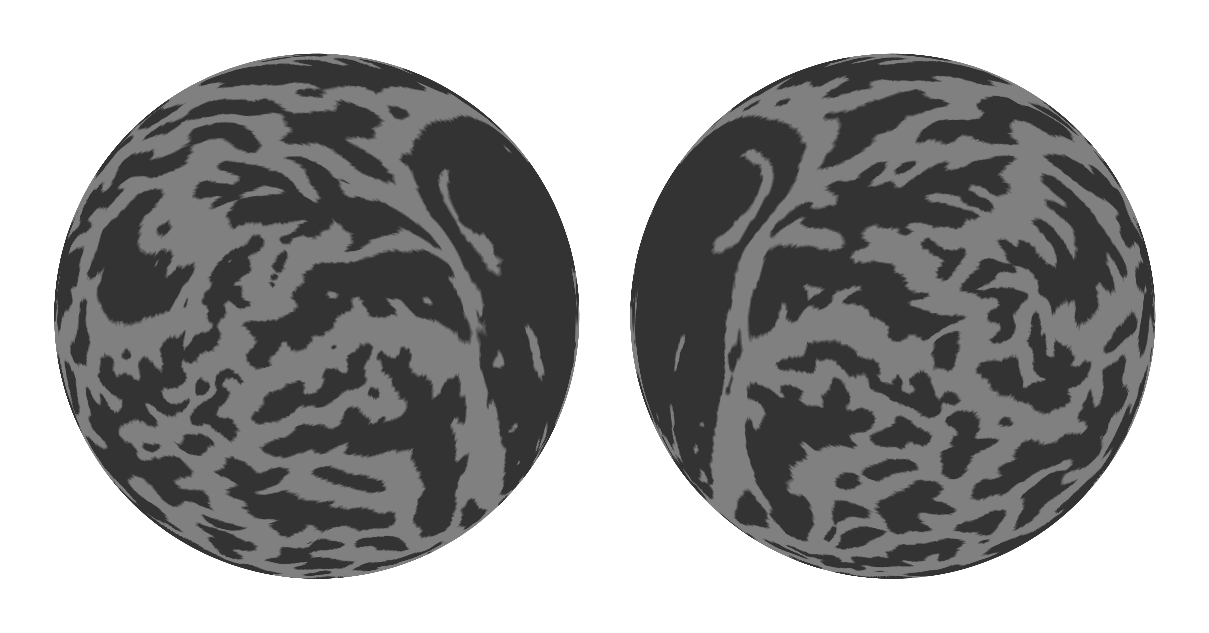

In [14]:
# We'll make two axes, one for each hemisphere.
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(4,2), dpi=72*4)
# Make sure there isn't a bunch of extra space around them.
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(flatmaps['lh'], axes=left_ax)
ny.cortex_plot(flatmaps['rh'], axes=right_ax)

left_ax.axis('off')
right_ax.axis('off');

## Plotting Basics

The basics of 2D plotting are very similar (nearly identical) to those of 3D plotting (see the `plotting-3D.ipynb` tutorial). The main difference is that instead of using the `ipyvolume` library for 3D plots, 2D plotting uses the `matplotlib` library (primarily the `matplotlib.pyplot` interface) to make 2D plots. A variety of tutorials for `matplotlib` can be found [here](https://matplotlib.org/stable/tutorials/index.html). This notebook will assume that you are reasonably familiar with `matplotlib` already.

To get started with 2D plotting, let's plot the flatmaps we just made above, but let's plot the `'V1_weight` property so that we can see if it successfully put V1 at the center of the flatmaps. 

If we want to see a property visualized on the cortical surface, we can plot the cortical surface using that property as the color.

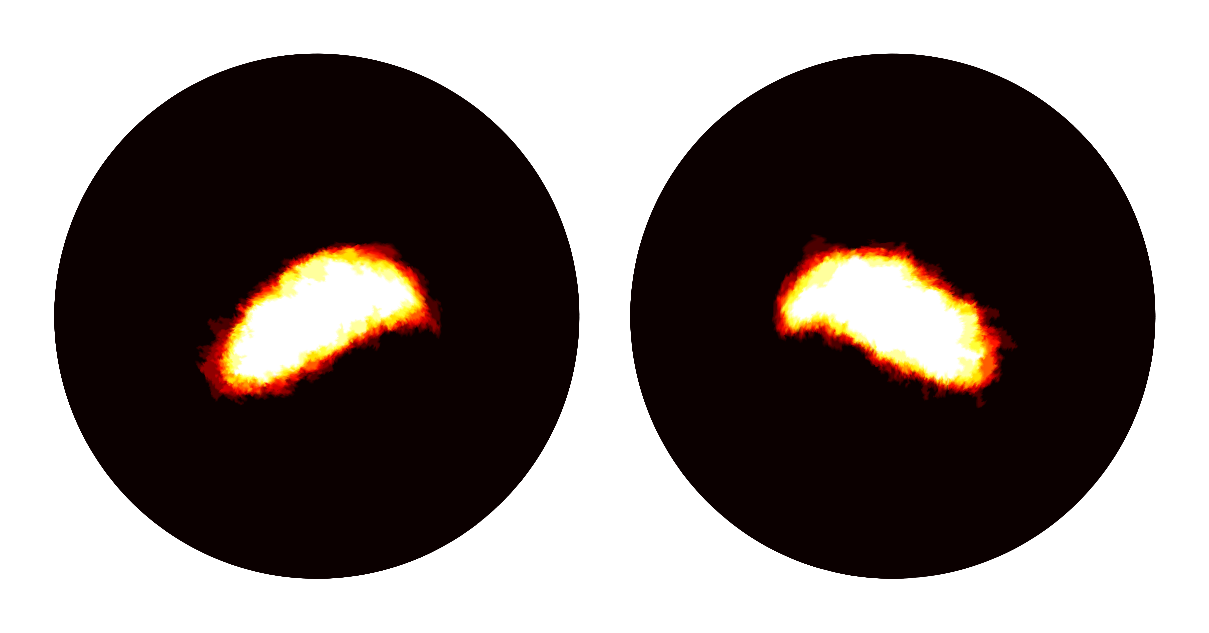

In [15]:
# We'll make two axes, one for each hemisphere.
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(4,2), dpi=72*4)
# Make sure there isn't a bunch of extra space around them.
fig.subplots_adjust(0,0,1,1,0,0)

# We provide the cortex_plot function with a property name that it should
# use for the color; we also provide a colormap (cmap).
ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color='V1_weight',
               cmap='hot')
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color='V1_weight',
               cmap='hot')

left_ax.axis('off')
right_ax.axis('off');

Notice that in the above code cell, we passed the string `'V1_weight'` to the `color` option. This can be a property name for a property of the first argument (the cortex or surface mesh), or any valid property itself. For example, we could pass the `V1_weight` property directly.

In this next cell, we make plots this way, but we use the 'cortex_label' property so that we can see that the medial wall ended up in the correct part of the flatmap.

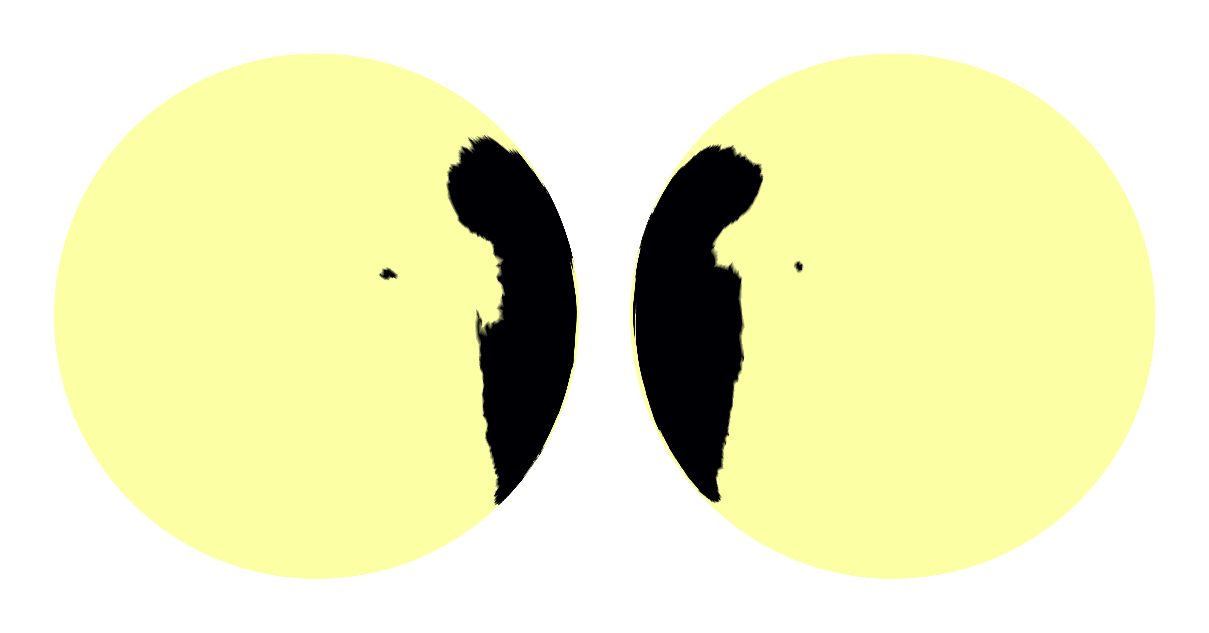

In [16]:
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(4,2), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0,0)

# Extract the properties from the flatmaps. Note that because the flatmaps
# have fewer vertices than the 3D meshes, we need to either get these from
# the flatmaps themselves or we need to extract the vertices in the flatmaps
# from the 3D mesh property, for example:
# mesh3D_v1_weight = sub.lh.prop('V1_weight')
# labels = flatmap['lh'].labels
# flatmap_v1_weight = mesh3D_v1_weight[labels]
lh_cortex_label = flatmaps['lh'].prop('cortex_label')
rh_cortex_label = flatmaps['rh'].prop('cortex_label')

# Plot these properties. Note two things:
# (1) We have to cast the cortex_label property to a float, because
#     cortex_plot doesn't expect boolean property values typically.
# (2) We use a different colormap because 'hot' for boolean values
#     looks black-and-white, which isn't especially useful in this
#     case. Using the colormap 'inferno', the medial wall should be
#     black, and the rest of cortex should be light yellow.
ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color=lh_cortex_label.astype('float'),
               cmap='inferno')
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color=rh_cortex_label.astype('float'),
               cmap='inferno')

left_ax.axis('off')
right_ax.axis('off');

### Masks and Underlays

The `cortex_plot` function accepts an option `mask` that allows one to color the cortex only at certain places. A very basic usage of the mask is to plot colors for only the vertices that are `True` in a particular property.

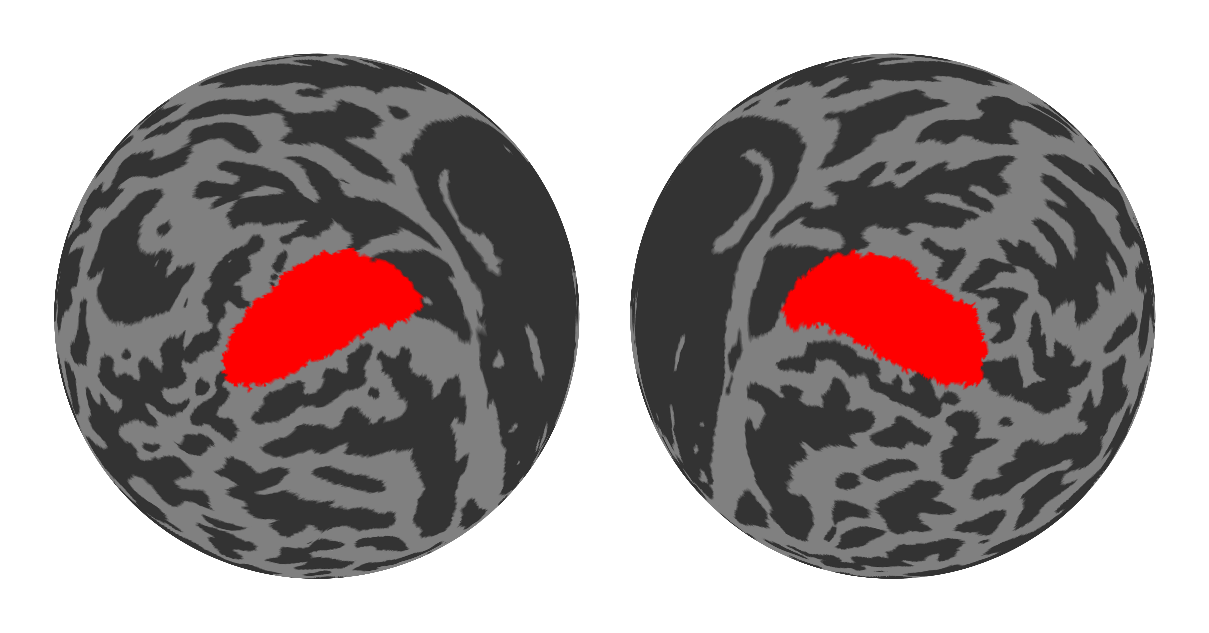

In [17]:
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(4,2), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0,0)

# We use a mask that consists of points in V1, and we'll color then red.
# Since the 'V1_weight' property gives the probability that each vertex
# is in V1, we will mask out vertices whose weight is below 0.5.
lh_v1_weight = flatmaps['lh'].prop('V1_weight')
rh_v1_weight = flatmaps['rh'].prop('V1_weight')
ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color='red',
               mask=(lh_v1_weight > 0.5))
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color='red',
               mask=(rh_v1_weight > 0.5))

left_ax.axis('off')
right_ax.axis('off');

The mask can be a property vector itself, but alternately, you can provide the name of a property that is already part of the cortex or surface object.

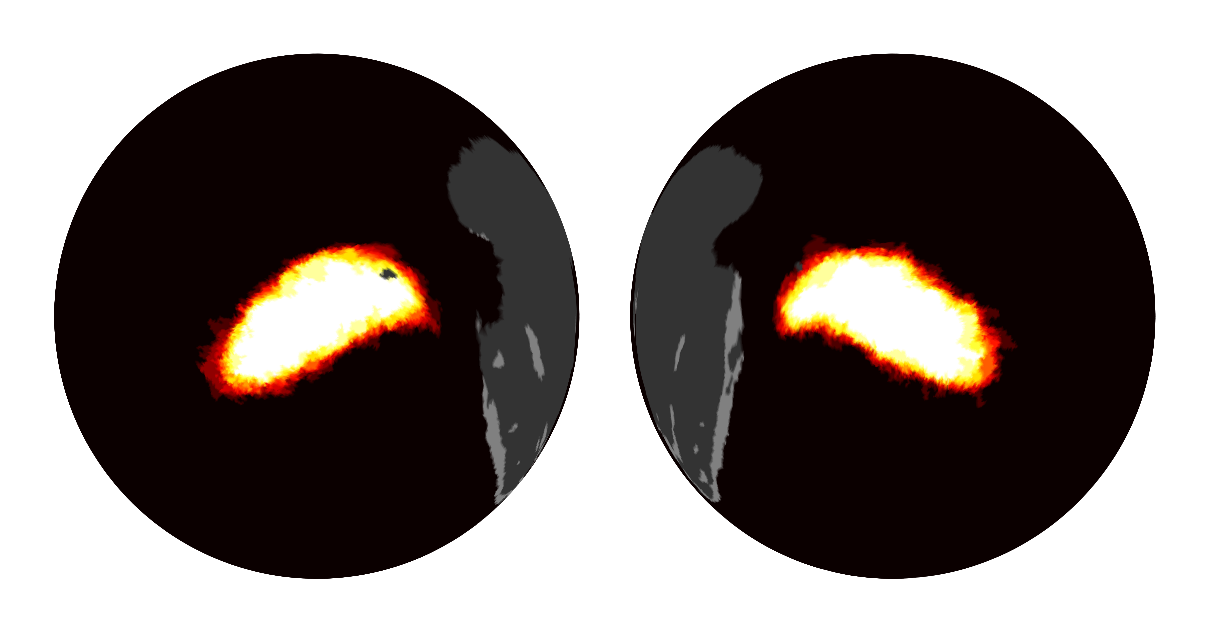

In [18]:
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(4,2), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0,0)

# We'll plot colors based on the V1_weight in these plots, but we'll only
# plot these colors on the cortical surface that isn't part of the medial
# wall by using the 'cortex_label' property as the mask.
ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color='V1_weight',
               cmap='hot',
               mask='cortex_label')
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color='V1_weight',
               cmap='hot',
               mask='cortex_label')

left_ax.axis('off')
right_ax.axis('off');

Mask also accepts a few alternative forms; these are described in the `ny.to_mask` function's documentation.

In [19]:
help(ny.to_mask)

Help on function to_mask in module neuropythy.geometry.mesh:

to_mask(obj, m=None, indices=None)
    to_mask(obj, m) yields the set of indices from the given vertex-set or itable object obj that
      correspond to the given mask m.
    to_mask((obj, m)) is equivalent to to_mask(obj, m).
    
    The mask m may take any of the following forms:
       * a list of vertex indices
       * a boolean array (one value per vertex)
       * a property name, which can be cast to a boolean array
       * a tuple (property, value) where property is a list of values, one per vertex, and value
         is the value that must match in order for a vertex to be included (this is basically
         equivalent to the mask (property == value); note that property may also be a property
         name
       * a tuple (property, min, max), which specifies that the property must be between min and
         max for a vertex to be included (min < p <= max)
       * a tuple (property, (val1, val2...)), which sp

Here's an example where we only plot the `'thickness'` property values for vertices whose V1_weight is greater than 0.5, using the `(property, min, max)` form of the mask option.

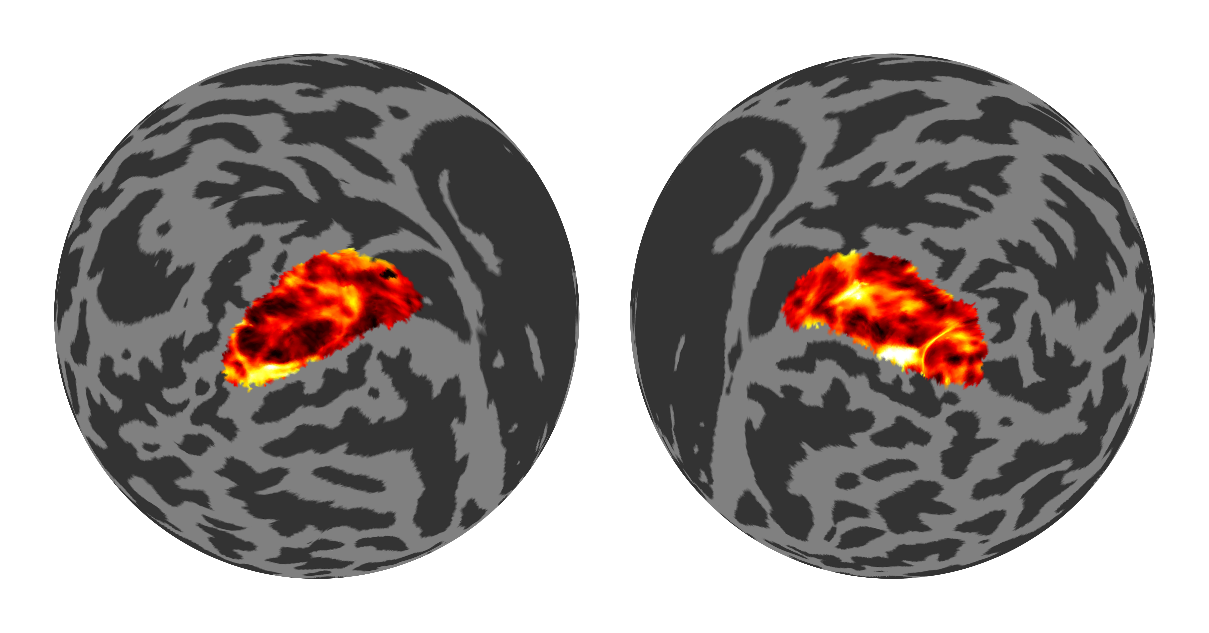

In [20]:
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(4,2), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0,0)

# V1 has relatively thin gray-matter, so we will limit the plot-color range
# (for the colormap) to be between 1 and 4 mm using the vmin and vmax
# options.
ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color='thickness',
               cmap='hot', vmin=1, vmax=4,
               mask=('V1_weight', 0.5, 1))
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color='thickness',
               cmap='hot', vmin=1, vmax=4,
               mask=('V1_weight', 0.5, 1))

left_ax.axis('off')
right_ax.axis('off');

Suppose you want to color only certain points on cortex, but you don't want the underly to be colored by curvature. The solution to this problem is to use the `underlay` option, which allows one to specify a color for the underlay.

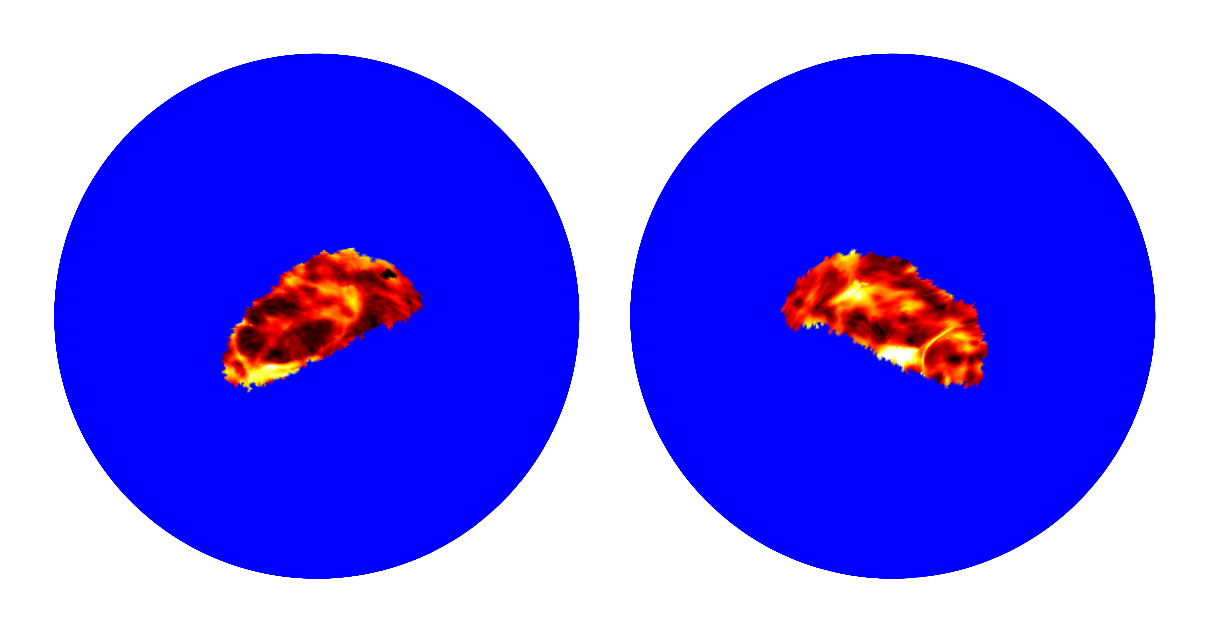

In [21]:
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(4,2), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color='thickness',
               cmap='hot', vmin=1, vmax=4,
               mask=('V1_weight', 0.5, 1),
               underlay='blue')
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color='thickness',
               cmap='hot', vmin=1, vmax=4,
               mask=('V1_weight', 0.5, 1),
               underlay='blue')

left_ax.axis('off')
right_ax.axis('off');

### Transparency

Although it is only sometimes useful, neuropythy supports transparency for both the mesh and the color. The `alpha` parameter allows one to modify the transparency of the vertex colors.

For example, if we wanted to make a plot showing where V1 was located but where the colors are partially transparent (allowing us to see the curvature map underneath the plot color), we could set the transparency to be a constant.

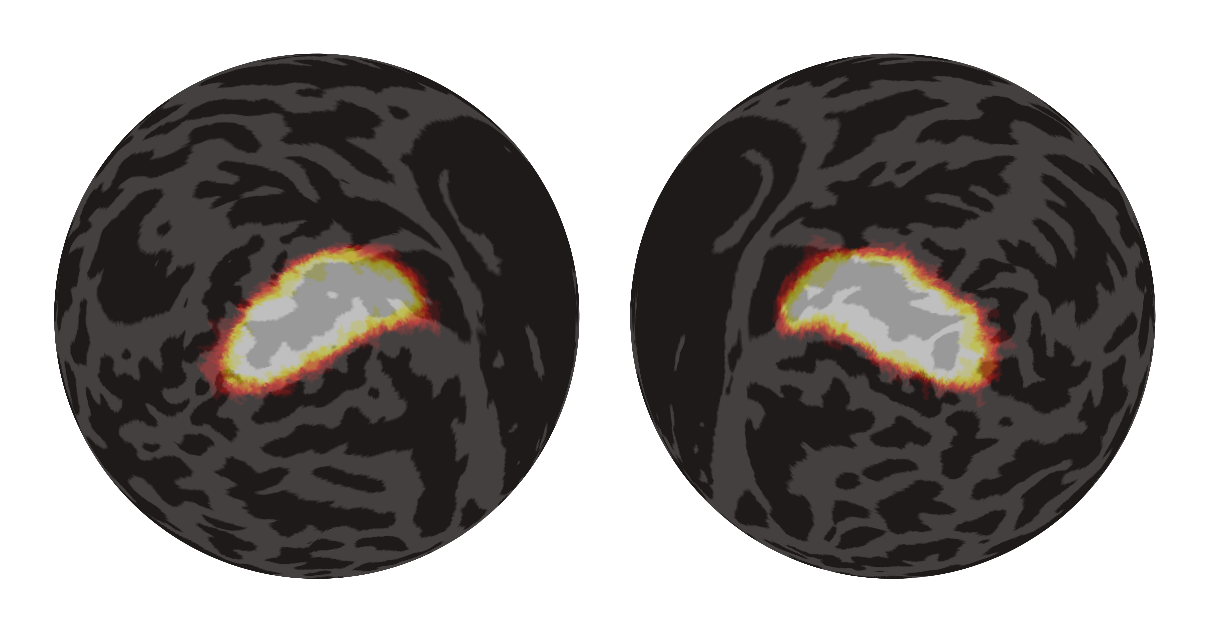

In [22]:
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(4,2), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color='V1_weight',
               cmap='hot',
               alpha=0.5)
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color='V1_weight',
               cmap='hot',
               alpha=0.5)

left_ax.axis('off')
right_ax.axis('off');

Alternately, we can make the mesh transparency depend on the property itself.

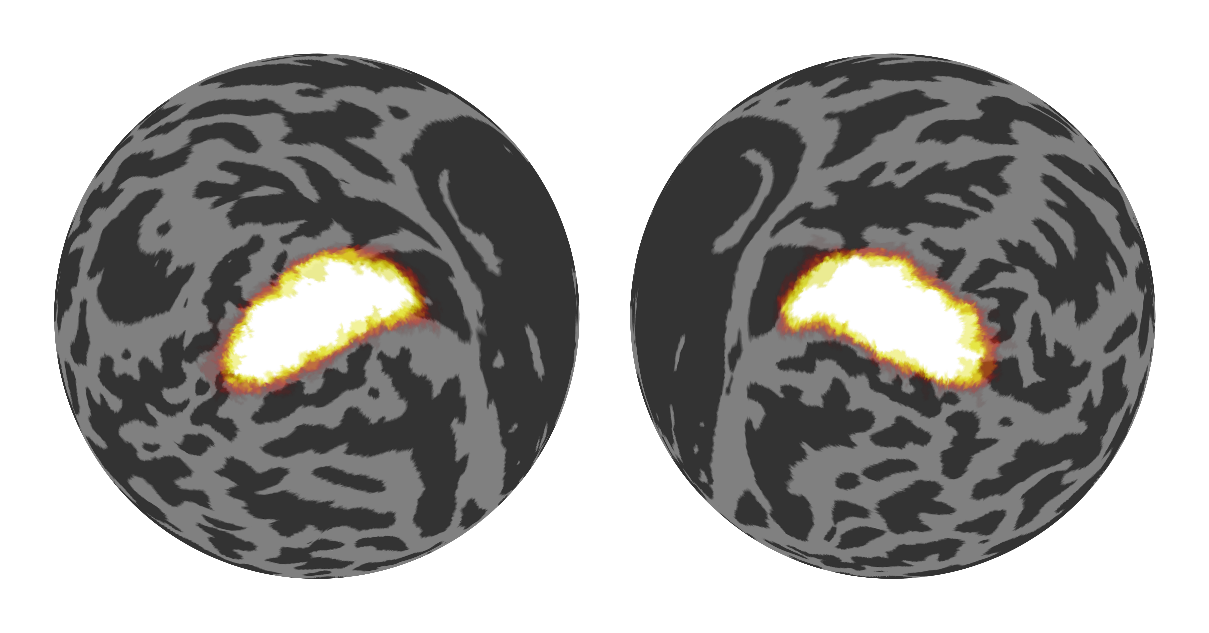

In [23]:
(fig, (left_ax, right_ax)) = plt.subplots(1,2, figsize=(4,2), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color='V1_weight',
               cmap='hot',
               alpha='V1_weight')
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color='V1_weight',
               cmap='hot',
               alpha='V1_weight')

left_ax.axis('off')
right_ax.axis('off');

## More Information

More help on the plotting functions can be found in the documentation for the `cortex_plot` function:

In [24]:
help(ny.cortex_plot)

Help on function cortex_plot in module neuropythy.graphics.core:

cortex_plot(mesh, *args, **opts)
    cortex_plot(mesh) calls either cortex_plot_2D or cortex_plot_3D depending on the dimensionality
      of the given mesh, and yields the resulting graphics object. All optional arguments supported
      by each is supported by cortex plot.
    
    The following options are accepted:
      * color (default: None) specifies the color to plot for each vertex; this argument may take a
        number of forms:
          * None, do not plot a color over the underlay (the default)
          * a matrix of RGB or RGBA values, one per vertex
          * a property vector or a string naming a property, in which case the cmap, vmin, and vmax
            arguments are used to generate colors
          * a function that, when passed a single argument, a dict of the properties of a single
            vertex, yields an RGB or RGBA list for that vertex.
      * cmap (default: 'eccenflat') specifies th